In [369]:
import requests
import json
import nferx_py.fn as nf
import matplotlib.pyplot as plt
import pandas as pd
from multiprocessing import pool
import seaborn as sns
from tqdm import tqdm
from nltk.stem import SnowballStemmer
from gensim.utils import simple_preprocess
import numpy as np
from tqdm.notebook import tqdm
import os
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import auc

In [2]:
stemmer = SnowballStemmer('english')

In [3]:
nf.authenticate('nfer','6eaa1d27bfa0639f2712191fa55df872')
nf.modify_defaults('server', 'preview')
nf.modify_defaults('api_server', 'preview')
AUTH = nf.AUTH

2020-05-13 11:56:00,120 : INFO : Authentication successful - nferX is online
2020-05-13 11:56:00,121 : INFO : Default parameter server modified
2020-05-13 11:56:00,122 : INFO : Default parameter api_server modified


### notes
1. Get local scores for all gene/cell combinations from single cell api for Tabula muris (study 2) and mouse cell atlas (study 15)
2. Do "intra-study" testing: for each Tabula Muris cluster, (1) identify the subset of genes to consider (e.g. top 0.05% by cohen's D vs. all other cells), (2) calculate cosine similarity between mean CP10K vector of this gene subset and the literature score vectors for all Tabula Muris cell types with this same gene subset. This would give us a ranked list of literature-derived labels for each cluster. Then repeat this with Mouse Cell Atlas. ---- Cosine sim did not work out---- Switched to calculating vector norms of literature scores of top genes from selected from cluster A, accross all clusters 

- For each cluster to label C:
    1. Select the top n genes by Cohen’s D (e.g. top 5, 10, 25)
    2. From API, get the fraction of cells in cluster C which express each gene
    3. From literature reference table, get the local scores between each reference cell type and the top n genes
    4. Multiply “Fraction cells expressing in cluster C” column by each “Ref_CellTypeX_LocalScores” column to get a set of “literature encoded expression vectors” for each reference cell type
    5. For each “Lit Encoded Vector” column, calculate L0, L1, L2, and L-inf norms
        L0: number of non-zero elements
        L1: sum of all values
        L2: square root of sum of squares
        L-inf: max value
    Output: four tables of Clusters To Label (rows) * Reference Cell Types 
    Table 1 = L0 norm, Table 2 = L1 norm, Table 3 = L2 norm, Table 4 = L-inf norm

-------------step 4 yet to be done------------------------
4. Do "inter-study" testing: for each Tabula Muris cluster, (1) identify the subset of genes to consider (e.g. top 0.05% by cohen's D vs. all other cells), (2) calculate cosine similarity between mean CP10K vector of this gene subset and the literature score vectors for all Mouse Cell Atlas cell types with this same gene subset. Then repeat this to label all Mouse Cell Atlas clusters using the literature vectors from the Tabula Muris dataset. This will require some handling of synonyms/cell "families" which I provided to Katie for this analysis ... but we could go over that later since step 2 alone will take some time to set up and optimize I think

### POST to single cell api to get the table

In [8]:
URL = 'https://pre-staging.nferx.com/singlecellapi/study2/summary?'
headers = {'content-type' : 'application/json'}
res = requests.post(url = URL, params = {'page': 1, 'rows': 3412880}, auth = AUTH)
data_all = pd.DataFrame(res.json()['result']['data'])
# d.drop(columns=['localScoreCellType', 'localScoreTissueType', 'greaterThanZero'], inplace = True)

# data_all.drop(columns=['localScoreTissueType', 'greaterThanZero'], inplace = True)
data_all.localScoreCellType = [d['localScore'] for d in data_all.localScoreCellType]
data_all['cluster'] = data_all.cellType.str.replace(' ', '_') + ';'+data_all.tissueType.str.replace(' ', '_')

2020-05-13 13:08:34,370 : INFO : NumExpr defaulting to 8 threads.


In [11]:
data_all.head()

,mean,cohenD,greaterThanZero,localScoreCellType,localScoreTissueType,countOfCells,cohendNA,geneId,cellType,tissueType,geneName,cluster
0,8.853313,8.359104,100.000000,0.615536,"{'localScore': 0.5205630660057068, 'globalScor...",155,False,19188,erythroblasts,bone marrow,Beta-s,erythroblasts;bone_marrow
1,7.706127,4.943145,100.000000,1.058810,"{'localScore': 3.3489274978637695, 'globalScor...",390,False,11271,pancreatic A cells,pancreas,Gcg,pancreatic_A_cells;pancreas
2,5.716988,4.647337,100.000000,2.573489,"{'localScore': 1.1692416667938232, 'globalScor...",24,False,23282,mast cells,lung,Tmsb4x,mast_cells;lung
3,5.122446,4.616773,99.977242,4.121519,"{'localScore': 3.4461004734039307, 'globalScor...",4394,False,5689,microglia,brain,Hexb,microglia;brain
4,5.003388,4.507700,100.000000,2.240599,"{'localScore': 5.230236530303955, 'globalScore...",89,False,17014,type II pneumocytes,lung,Sftpb,type_II_pneumocytes;lung


In [12]:
gene_cluster_localScore = data_all.pivot(index = 'geneName', columns = 'cluster', values = 'localScoreCellType')
gene_cluster_cohend = data_all.pivot(index = 'geneName', columns = 'cluster', values = 'cohenD')

In [37]:
def get_top_genes_vector(df, top_n = None, quantile = 0.995, cols = ['cohenD', 'mean', 'greaterThanZero']):
    #matrix 1: top-genes means (shape: 1*N)
    df = df.set_index('geneName')
    if top_n:
        return df.sort_values(by = 'cohenD', ascending = False)[cols].iloc[0:top_n]
    
    cutoff = df.cohenD.quantile([0.995]).values[0]
    top_genes_vec = df.loc[df.cohenD >= cutoff, cols]
    
    
    return top_genes_vec

In [114]:
def get_matrix(top_genes_subset, metric = 'cosine'):
    cluster = top_genes_subset.cluster[0]
    #matrix 1: top-genes means (shape: 1*N)
    top_genes_mean = top_genes_subset.loc[:, ['geneName', 'mean']].set_index('geneName').transpose()
    #matrix 2: top-genes(N) vs all - clusters'(M) local score (shape: N*M)
    gene_local_score_subset = gene_cluster_localScore.loc[top_genes_mean.columns,:]
    
    #get literature vector
    lit_encoded_subset = gene_local_score_subset.multiply(top_genes_subset.loc[:, 'greaterThanZero'].values, 
                                                              axis = 0)
    
    #apply norms
    
    if metric == 'norm-all':
        score0 = (lit_encoded_subset != 0).sum()
        score1 = lit_encoded_subset.sum()
        score2 = lit_encoded_subset.pow(2).sum().pow(1/2)
        scoreINF = lit_encoded_subset.max()
        
        return [score0, score1, score2, scoreINF]
    
    elif metric == 'cosine':
        assert top_genes_mean.shape[1] == lit_encoded_subset.shape[0]
        score = cosine_similarity(top_genes_mean.to_numpy(), lit_encoded_subset.transpose())
        score = pd.Series(score.reshape(-1), index = lit_encoded_subset.columns)
    elif metric == 'l0':
        score = (lit_encoded_subset != 0).sum()
    elif metric == 'l1':
        score = lit_encoded_subset.sum()
    elif metric == 'l2':
        score = lit_encoded_subset.pow(2).sum().pow(1/2)
    elif metric == 'inf':
        score = lit_encoded_subset.max()
    
    return score

In [138]:
#top n genes; all norrms
n_genes = [5, 10, 25]
metric = 'norm-all'
savepath = './data/norrms/'
for n in n_genes:
    cluster_mean_vectors = data_all.groupby('cluster').apply(lambda x: get_top_genes_vector(x, top_n = n))
    cluster_mean_vectors.loc[:, 'greaterThanZero'] = cluster_mean_vectors.loc[:, 'greaterThanZero']/100
    cluster_mean_vectors = cluster_mean_vectors.reset_index()
    res = cluster_mean_vectors.groupby('cluster').apply(lambda x: get_matrix(x, metric))
    if metric == 'norm-all':
        L0 = L1 = L2 = Linf = pd.DataFrame()
        dfs = [L0, L1, L2, Linf]
        norms = ['L0', 'L1', 'L2', 'Linf']
        for i, df in enumerate(dfs):
            df = res.apply(lambda x: x[i])
            df.index = df.index + '_TRUE'
            df.to_csv(savepath+'%s_norm_%s_genes.csv'%(norms[i], n))
    else:
        res.index = res.index + '_TRUE'
        res.to_csv(savepath+'%s_top_%s_genes.csv'%(metric, n))

L0
L1
L2
Linf
L0
L1
L2
Linf
L0
L1
L2
Linf


In [129]:
#mappings frorm pat
cell_maps = pd.read_csv('./data/TM_clusters_map.csv')
cell_maps.set_index('cluster', inplace=True)

files = os.listdir('./data/norms/')

In [557]:
df.T.reset_index().drop_duplicates()

map,map,macrophages,astrocytes,B cells,B cells,B cells,B cells,B cells,B cells,B cells,...,proximal tubule cells,T cells,endothelial cells,stromal cells,stromal cells,smooth muscle cells,epidermal cells,stromal cells,stromal cells,type II pneumocytes
0,macrophages,3.735022,1.746565,0.903701,2.393877,0.751316,1.069484,1.778630,1.888908,3.451924,...,0.294350,2.078249,1.036125,1.650429,1.612457,1.485357,1.408511,1.792774,2.413095,4.083411
1,astrocytes,3.722504,8.727008,1.212409,2.049882,0.616065,1.183044,2.121779,2.142693,0.679379,...,0.842171,1.931553,1.905285,1.917942,3.219798,2.052824,1.231245,4.568105,0.639494,0.000000
2,B cells,4.278557,3.196431,7.825050,3.913730,0.736366,7.130207,10.844165,9.076958,12.008922,...,0.544872,3.786705,1.968689,3.430938,5.146968,2.132104,4.120318,2.080771,1.381234,0.815164
9,basal_cells,3.700906,1.398987,0.156127,0.350016,2.096523,0.279246,0.367600,2.128452,1.136388,...,0.755283,0.190356,0.548424,1.344478,0.701157,2.084307,7.844985,1.453752,0.423845,2.032446
10,basal_cells,2.822798,0.953461,0.156127,0.275164,2.096523,0.279246,0.343902,2.124487,0.892614,...,0.755283,0.190356,0.548424,1.341319,0.572580,1.511618,6.645839,0.991867,0.311510,1.996264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,stromal cells,6.618688,2.221783,4.011786,1.795384,1.177939,3.563964,4.902922,4.670347,5.159145,...,2.797169,1.673735,2.780052,3.378097,5.995116,2.799056,4.554153,2.565847,1.692971,3.818023
143,smooth muscle cells,1.304079,3.296259,0.621223,0.706111,0.000000,0.390355,0.354694,0.355946,0.773229,...,0.103131,0.615913,0.276782,0.795962,1.505096,6.778809,0.915501,2.030346,1.068220,0.373472
144,epidermal cells,6.618688,2.221783,4.011786,1.795384,1.177939,3.563964,4.902922,4.670347,5.159145,...,2.797169,1.673735,2.780052,3.378097,5.995116,2.799056,4.554153,2.565847,1.692971,3.818023
145,stromal cells,4.401711,1.414409,2.298378,0.794425,0.089629,2.017679,3.040603,2.986424,2.846705,...,2.071709,0.774806,2.192574,3.135382,3.054871,4.189022,1.967629,3.650548,2.406722,0.932533


In [606]:
#create rank thrreshold matrix
n = [5, 10, 25]
files = os.listdir(savepath)
metric_rank_df = pd.DataFrame(range(0,97), columns=['rank'])
for file in files:
#     print(file.rstrip('.csv').upper().split('_'))
    s = file.rstrip('.csv').upper().split('_')
    col_name = s[0] + ' | ' + s[-2]
    df = pd.read_csv(savepath+file, index_col = 0)
    df.columns = df.index = df.columns.str.replace(';|-', '.') 
    df.columns = df.index = cell_maps.loc[df.columns, 'map'] 
    ranks_all = df.T.reset_index().drop_duplicates().set_index('map').apply(lambda x: 
                                                                      x.sort_values(ascending = False).index, 
                             axis = 0).reset_index(drop = True).apply(lambda x:
                                                                      x[x.name == x].index.to_list())
    cluster_ranks = ranks_all.apply(lambda x:x[0])
    metric_rank_df[col_name] = metric_rank_df.loc[:,'rank'].apply(lambda x: 
                                                                       (cluster_ranks < x).sum()/148)

In [607]:
metric_rank_df['rank'] = metric_rank_df['rank']/96
var_name_ = 'Measure|Top N genes'
plot_df = metric_rank_df.melt(id_vars = 'rank', var_name = var_name_, value_name='n_top_rank_clusters')

plot_df['norm'] = [x[0] for x in plot_df[var_name_].str.split('|')]
plot_df['n_top_genes'] = [str(x[1]) for x in plot_df[var_name_].str.split('|')]
plot_df['n_top_genes'] = plot_df.n_top_genes.astype('category')

In [608]:
auc_all = plot_df.groupby(['norm', 'n_top_genes']).apply(lambda x: auc(x['rank'], x['n_top_rank_clusters'])).to_frame()
auc_all.columns = ['auc']
auc_all.sort_values(by = 'auc', ascending = False)

auc
norm    n_top_genes          
L1       10          0.857334
L2       25          0.855398
         10          0.854800
L1       5           0.853604
         25          0.852090
L2       5           0.851914
LINF     25          0.845650
         5           0.840231
         10          0.838612
L0       25          0.793849
         10          0.789203
COSINE   10          0.788288
L0       5           0.788007
COSINE   5           0.786669
         25          0.775690

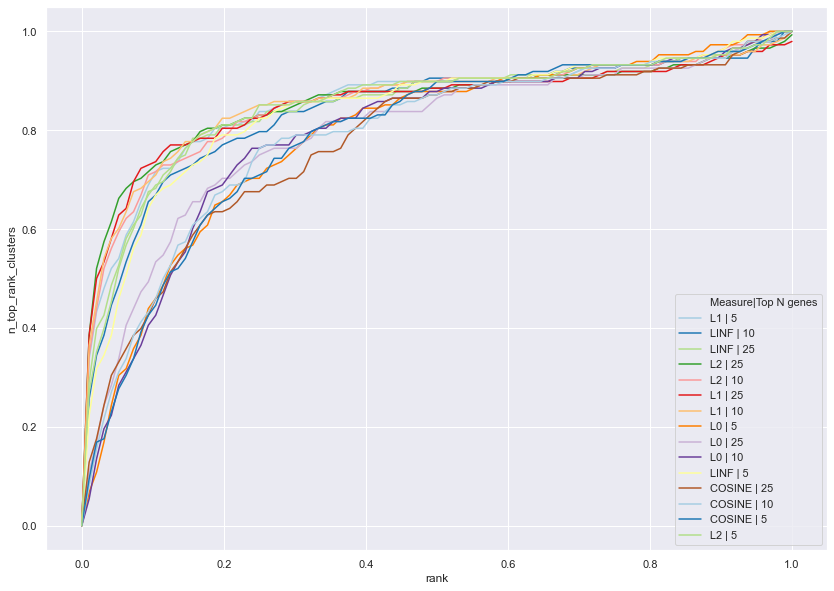

In [609]:
sns.set()
plt.figure(figsize=(14,10))
sns.lineplot(data = plot_df, 
             x = 'rank', 
             y = 'n_top_rank_clusters',
             hue='Measure|Top N genes', hue_order=[],
             palette=sns.color_palette("Paired", 15))

### Previous code

In [61]:
cluster_mean_vectors.loc[slice('Alveolar_macrophages;lung')]

cohenD      mean  greaterThanZero
cluster                   geneName                                     
Alveolar_macrophages;lung Chi3l3    2.911539  4.482258       100.000000
                          Tmsb4x    2.888863  5.654968       100.000000
                          Sepx1     2.431341  2.659609        99.420290
                          Cd44      2.388964  2.767570        99.710145
                          Serf2     2.347590  3.166469        99.710145

In [ ]:
collection =  'patrick-cells-pl-200304'
n = 10
def query_lab(gene_list, n=n, collection=collection, window = 101):
    result_df = pd.DataFrame()
    for gene in tqdm(gene_list[0:n]): 
        query = gene
        res = nf.get_signals_lab(query = query, control_collection = collection, 
                                 window = window)

        if type(res)!= str:
            res = pd.DataFrame(res)
            res['gene'] = gene
            result_df = pd.concat([result_df, res])
        #res.token = res.token.str.upper()
     
    return result_df.pivot(index = 'gene', columns = 'token', values = 'score').astype('float32')

In [ ]:
df_test = top_genes.iloc[0:1].apply(query_lab)

In [ ]:
df_all = top_genes.apply(query_lab)

In [ ]:
syns_all  =  set([tok for ls in syns for tok in ls])
def sort_df(df, q = [0.3, 0.5, 0.75], by = [0.75, 0.5, 0.3]):
    df_collapsed = pd.DataFrame()
    df = df.T
    no_match = df.index.difference(syns_all)
#     print(no_match)
    df.insert(loc = 0, column = 'count', value = n - df.isna().sum(1))
    for i, syn in tqdm(enumerate(syns)):
        df_subset = df[df.index.isin(syn)]
        if not df_subset.empty:
#             print(i)
#             print('\n',df_subset.index)
            
            df_idx = df_subset['count'].idxmax()
            df_max = df_subset.max()
            df_max.name = df_idx
            df_collapsed = pd.concat([df_collapsed, df_max], axis=1)
    if not df.loc[no_match,:].empty:
        df_collapsed = pd.concat([df_collapsed, df.loc[no_match,:].T], axis = 1)
    quantiles = df_collapsed.quantile(q, axis = 0)
    df_collapsed = pd.concat([quantiles, df_collapsed]).T
    df_collapsed = df_collapsed.sort_values(by = by, ascending = False)
    
    return df_collapsed.drop_duplicates()

In [ ]:
df_all[0].T

In [ ]:
sorted_dfs = list(map(sort_df, df_all))

In [ ]:
z = df_all[0].columns.difference(syns_all)

In [ ]:
df_all[0].loc[:,'yolk_sac_derived_macrophages']

In [ ]:
lit_df = pd.DataFrame()
for i, idx in enumerate(top_genes.index):
    df = sorted_dfs[i].copy(deep = True)
#     df.insert(loc = 0, column = 'count', value = n - df.isna().sum(1))
    df.insert(loc = 0, column = 'tissue', value = idx[0])
    df.insert(loc = 0, column = 'true_cell', value = idx[1])
    df = df.reset_index(drop = False, inplace = False)
    df.columns = ['token'] + df.columns[1:].to_list()
#     df = df[df['count'] > 3]
    lit_df = pd.concat([lit_df, df.loc[0:10, ['token', 'true_cell', 'tissue', 'count']]])

In [ ]:
lit_df.to_csv('./data/t10_genes_per_cluster.csv')

In [ ]:
lit_df

In [ ]:
ees_tokens = pd.read_csv('./data/appendTokens.csv', sep = '\t', header=None)

In [ ]:
ees_tokens.columns = ['token', 'syn']

In [ ]:
synonyms = ees_tokens.groupby('token').apply(lambda x: x.syn.to_list())

In [ ]:
all_syns = [set([idx]+syn) for idx, syn in synonyms.iteritems()]

In [ ]:
tokens = sorted_dfs[0].index
syn_mat = pd.DataFrame(np.eye(len(tokens)), index=idx, columns=idx)

In [ ]:
ees_ = ees_tokens.copy(deep = True)
ees_['val'] = 1
ees_1 = pd.pivot_table(ees_, index='token', columns='syn', values = 'val').fillna(0)
ees_2 = pd.pivot_table(ees_, index='syn', columns='token', values = 'val').fillna(0)

In [ ]:
ees_1.index.intersection(ees_2.index)

In [ ]:
len(all_syns)

In [ ]:
subset = {i: [] for i in range(len(all_syns))}
duplicates = {i: [] for i in range(len(all_syns))}
for i, syn_set in enumerate(all_syns):
    for j, syn_set_ in enumerate(all_syns):
        if (i!=j) & (len(syn_set.intersection(syn_set_)) > 0):
            print('\n',i, j, '\nIntersection: ', syn_set.intersection(syn_set_))
            if syn_set_ == syn_set:
                duplicates[i].append(j)
            else:
                subset[i].append(j)
                
                

In [ ]:
subset

In [ ]:
syns = []
for k, v in subset.items():
    if v:
        syn_subset = synonyms.iloc[[k]+v]
        print(syn_subset.index)
        s = list(set(syn_subset.explode().to_list() + syn_subset.index.to_list()))
        if s not in syns:
            syns.append(s)
    else:
        syns.append(list(set(synonyms.iloc[k] + [synonyms.index[k]])))

In [ ]:
syns

In [ ]:
d[d.index.isin(syns[1])]